In [22]:
import os, copy, sys
import numpy as np
import pandas as pd
from typing import List, Tuple
import matplotlib.pyplot as plt

In [23]:
# Run this cell to remove pool_alice_code from package namespace, and reimport it with most recent changes
sys.modules.pop("pool_alice_code",None)
import pool_alice_code_NO_BATCH_CORRELATION as pool_alice_code

## Load data

In [24]:
os.getcwd()

'/home/ethan/02750-automation/automation_final_project/P_ALICE'

In [25]:
X: np.ndarray = np.load('../data/abalone_age/X.npy')
y: np.ndarray  = np.load('../data/abalone_age/y.npy')
columns='Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight'.split(',')
X_df = pd.DataFrame(X,columns=columns)
num_original_features = len(X[0])

In [26]:
X_df.shape

(4177, 8)

# constants

In [27]:
SEEDS = [i*1001 for i in range(1,6)]

SEEDS

[1001, 2002, 3003, 4004, 5005]

In [28]:
BATCH_SIZE = 16

# P-ALICE, weighted linear regression

In [29]:
X_pool_linear = np.vstack((X.T,np.ones(len(X)))).T
X_pool_linear

array([[0.    , 0.455 , 0.365 , ..., 0.101 , 0.15  , 1.    ],
       [0.    , 0.35  , 0.265 , ..., 0.0485, 0.07  , 1.    ],
       [1.    , 0.53  , 0.42  , ..., 0.1415, 0.21  , 1.    ],
       ...,
       [0.    , 0.6   , 0.475 , ..., 0.2875, 0.308 , 1.    ],
       [1.    , 0.625 , 0.485 , ..., 0.261 , 0.296 , 1.    ],
       [0.    , 0.71  , 0.555 , ..., 0.3765, 0.495 , 1.    ]])

In [30]:
num_features_linear = len(X_pool_linear[0])
basis_funcs_linear: List[np.ufunc] = [pool_alice_code.identity_basis for _ in range(num_features_linear)] # type: ignore
try:
    abalone_age_linear_palice_16: np.ndarray = np.load('../results/abalone_age_linear_palice_16.npy')
    print("RESULTS ALREADY OBTAINED")
except:
    abalone_age_linear_palice_16 = pool_alice_code.simulate_pool_alice_n_times(n=len(SEEDS),seeds=SEEDS,X_pool=X_pool_linear,y_pool=y,basis_funcs=basis_funcs_linear,batch_size=BATCH_SIZE,passive_learning=False)
    np.save('../results/abalone_age_linear_palice_16.npy', abalone_age_linear_palice_16)


RESULTS ALREADY OBTAINED


# passive (random) learning, linear regression

In [31]:
try:
    abalone_age_linear_random_16: np.ndarray = np.load('../results/abalone_age_linear_random_16.npy')
    print("RESULTS ALREADY OBTAINED")
except:
    abalone_age_linear_random_16 = pool_alice_code.simulate_pool_alice_n_times(n=len(SEEDS),seeds=SEEDS,X_pool=X_pool_linear,y_pool=y,basis_funcs=basis_funcs_linear,passive_learning=True,batch_size=BATCH_SIZE)
    
    np.save('../results/abalone_age_linear_random_16.npy', abalone_age_linear_random_16)

RESULTS ALREADY OBTAINED


# P-ALICE, nonlinear regression 1

## prepare the nonlinear regression of the data

In [32]:
basis_funcs_nonlinear_1 = []
X_pretransformation_nonlinear_1 = copy.deepcopy(X_df)

# for the original features, they will not be edited
for i in range(num_original_features):
    basis_funcs_nonlinear_1.append(pool_alice_code.identity_basis)

for i in range(num_original_features):
    feature_i_name = X_df.columns[i]

    # add squared feature
    feature_i_name_squared = feature_i_name + '^2'
    X_pretransformation_nonlinear_1[feature_i_name_squared] = X_df[feature_i_name]
    basis_funcs_nonlinear_1.append(pool_alice_code.squared_basis)

    # DECIDED TO NOT USE CUBIC FEATURES, since adding them causes the resampling bias function to go negative,
    # WHICH im sure has something to do with the linear independence of features and/or the consistency of the 
    # linear system of equations represented by the data matrix and target (i.e. the number of samples vs number of 
    # features for overdetermined vs underdetermined vs exact)

    # # add cubed feature
    # feature_i_name_cubed = feature_i_name + '^3'
    # X_pretransformation_nonlinear_1[feature_i_name_cubed] = X_df[feature_i_name]
    # basis_funcs_nonlinear_1.append(pool_alice_code.cubed_basis)

    # add first order interactions
    for j in range(i,num_original_features): # ranging from i to num_original_features prevents X1*X2 and X2*X1
        if i != j:
            feature_j_name = X_df.columns[j]
            interaction_name = feature_i_name + '*' + feature_j_name
            X_pretransformation_nonlinear_1[interaction_name] = X_df[feature_i_name] * X_df[feature_j_name]
            basis_funcs_nonlinear_1.append(pool_alice_code.identity_basis)


In [33]:
X_pretransformation_nonlinear_1.shape

(4177, 44)

In [34]:
# add a column of 1s for the y-intercept, and add identity basis for this column
X_pool_nonlinear_1 = np.vstack((X_pretransformation_nonlinear_1.T,np.ones(len(X_pretransformation_nonlinear_1)))).T
num_features_nonlinear_1 = len(X_pool_nonlinear_1[0])

if len(basis_funcs_nonlinear_1) != X_pool_nonlinear_1.shape[1]:
    basis_funcs_nonlinear_1.append(pool_alice_code.identity_basis)
print(f"len(basis_funcs_nonlinear_1)={len(basis_funcs_nonlinear_1)}")
print(f"X_pool_nonlinear_1.shape={X_pool_nonlinear_1.shape}")

len(basis_funcs_nonlinear_1)=45
X_pool_nonlinear_1.shape=(4177, 45)


In [35]:
try:
    abalone_age_nonlinear_palice_16: np.ndarray = np.load('../results/abalone_age_nonlinear_palice_16.npy')
    print("RESULTS ALREADY OBTAINED")
except:
    abalone_age_nonlinear_palice_16 = pool_alice_code.simulate_pool_alice_n_times(n=len(SEEDS),seeds=SEEDS,X_pool=X_pool_nonlinear_1,y_pool=y,basis_funcs=basis_funcs_nonlinear_1,batch_size=BATCH_SIZE,passive_learning=False)
    np.save('../results/abalone_age_nonlinear_palice_16.npy', abalone_age_nonlinear_palice_16)

RESULTS ALREADY OBTAINED


#  random (passive), nonlinear regression 1

In [36]:
try:
    abalone_age_nonlinear_random_16: np.ndarray = np.load('../results/abalone_age_nonlinear_random_16.npy')
    print("RESULTS ALREADY OBTAINED")
except:
    abalone_age_nonlinear_random_16 = pool_alice_code.simulate_pool_alice_n_times(n=len(SEEDS),seeds=SEEDS,X_pool=X_pool_nonlinear_1,y_pool=y,basis_funcs=basis_funcs_nonlinear_1,batch_size=BATCH_SIZE,passive_learning=True)
    np.save('../results/abalone_age_nonlinear_random_16.npy', abalone_age_nonlinear_random_16)

RESULTS ALREADY OBTAINED


# Get the batch_size 32 results

In [37]:
x_train_length = len(X)*0.8
twenty_percent = int(x_train_length * 0.20)
fifty_percent = int(x_train_length * 0.5)
num_samples_axis = range(twenty_percent,fifty_percent+1,BATCH_SIZE)

In [38]:
# np.save('num_samples_axis_abalone.npy',np.array(num_samples_axis))

In [39]:
print(len(num_samples_axis))
print(len(list(num_samples_axis[::2])))
abalone_age_linear_random_16.shape

63
32


(5, 63)

In [40]:
abalone_age_linear_random_16[:,::2].shape

(5, 32)

In [41]:
try:
    np.load('../results/abalone_age_linear_random_32.npy')
except:
    print("this happened")
    np.save('../results/abalone_age_linear_palice_32.npy',abalone_age_linear_palice_16[:,::2])
    np.save('../results/abalone_age_linear_random_32.npy',abalone_age_linear_random_16[:,::2])
    np.save('../results/abalone_age_nonlinear_palice_32.npy',abalone_age_nonlinear_palice_16[:,::2])
    np.save('../results/abalone_age_nonlinear_random_32.npy',abalone_age_nonlinear_random_16[:,::2])

# summarize results in plot

In [42]:
means_1_active = np.mean(abalone_age_linear_palice_16,axis=0)
means_1_passive = np.mean(abalone_age_linear_random_16,axis=0)
means_palice_nonlinear = np.mean(abalone_age_nonlinear_palice_16,axis=0)
means_passive_nonlinear = np.mean(abalone_age_nonlinear_random_16,axis=0)

stds_1_active = np.std(abalone_age_linear_palice_16,axis=0)
stds_1_passive = np.std(abalone_age_linear_random_16,axis=0)
stds_palice_nonlinear= np.std(abalone_age_nonlinear_palice_16,axis=0)
stds_passive_nonlinear = np.std(abalone_age_nonlinear_random_16,axis=0)


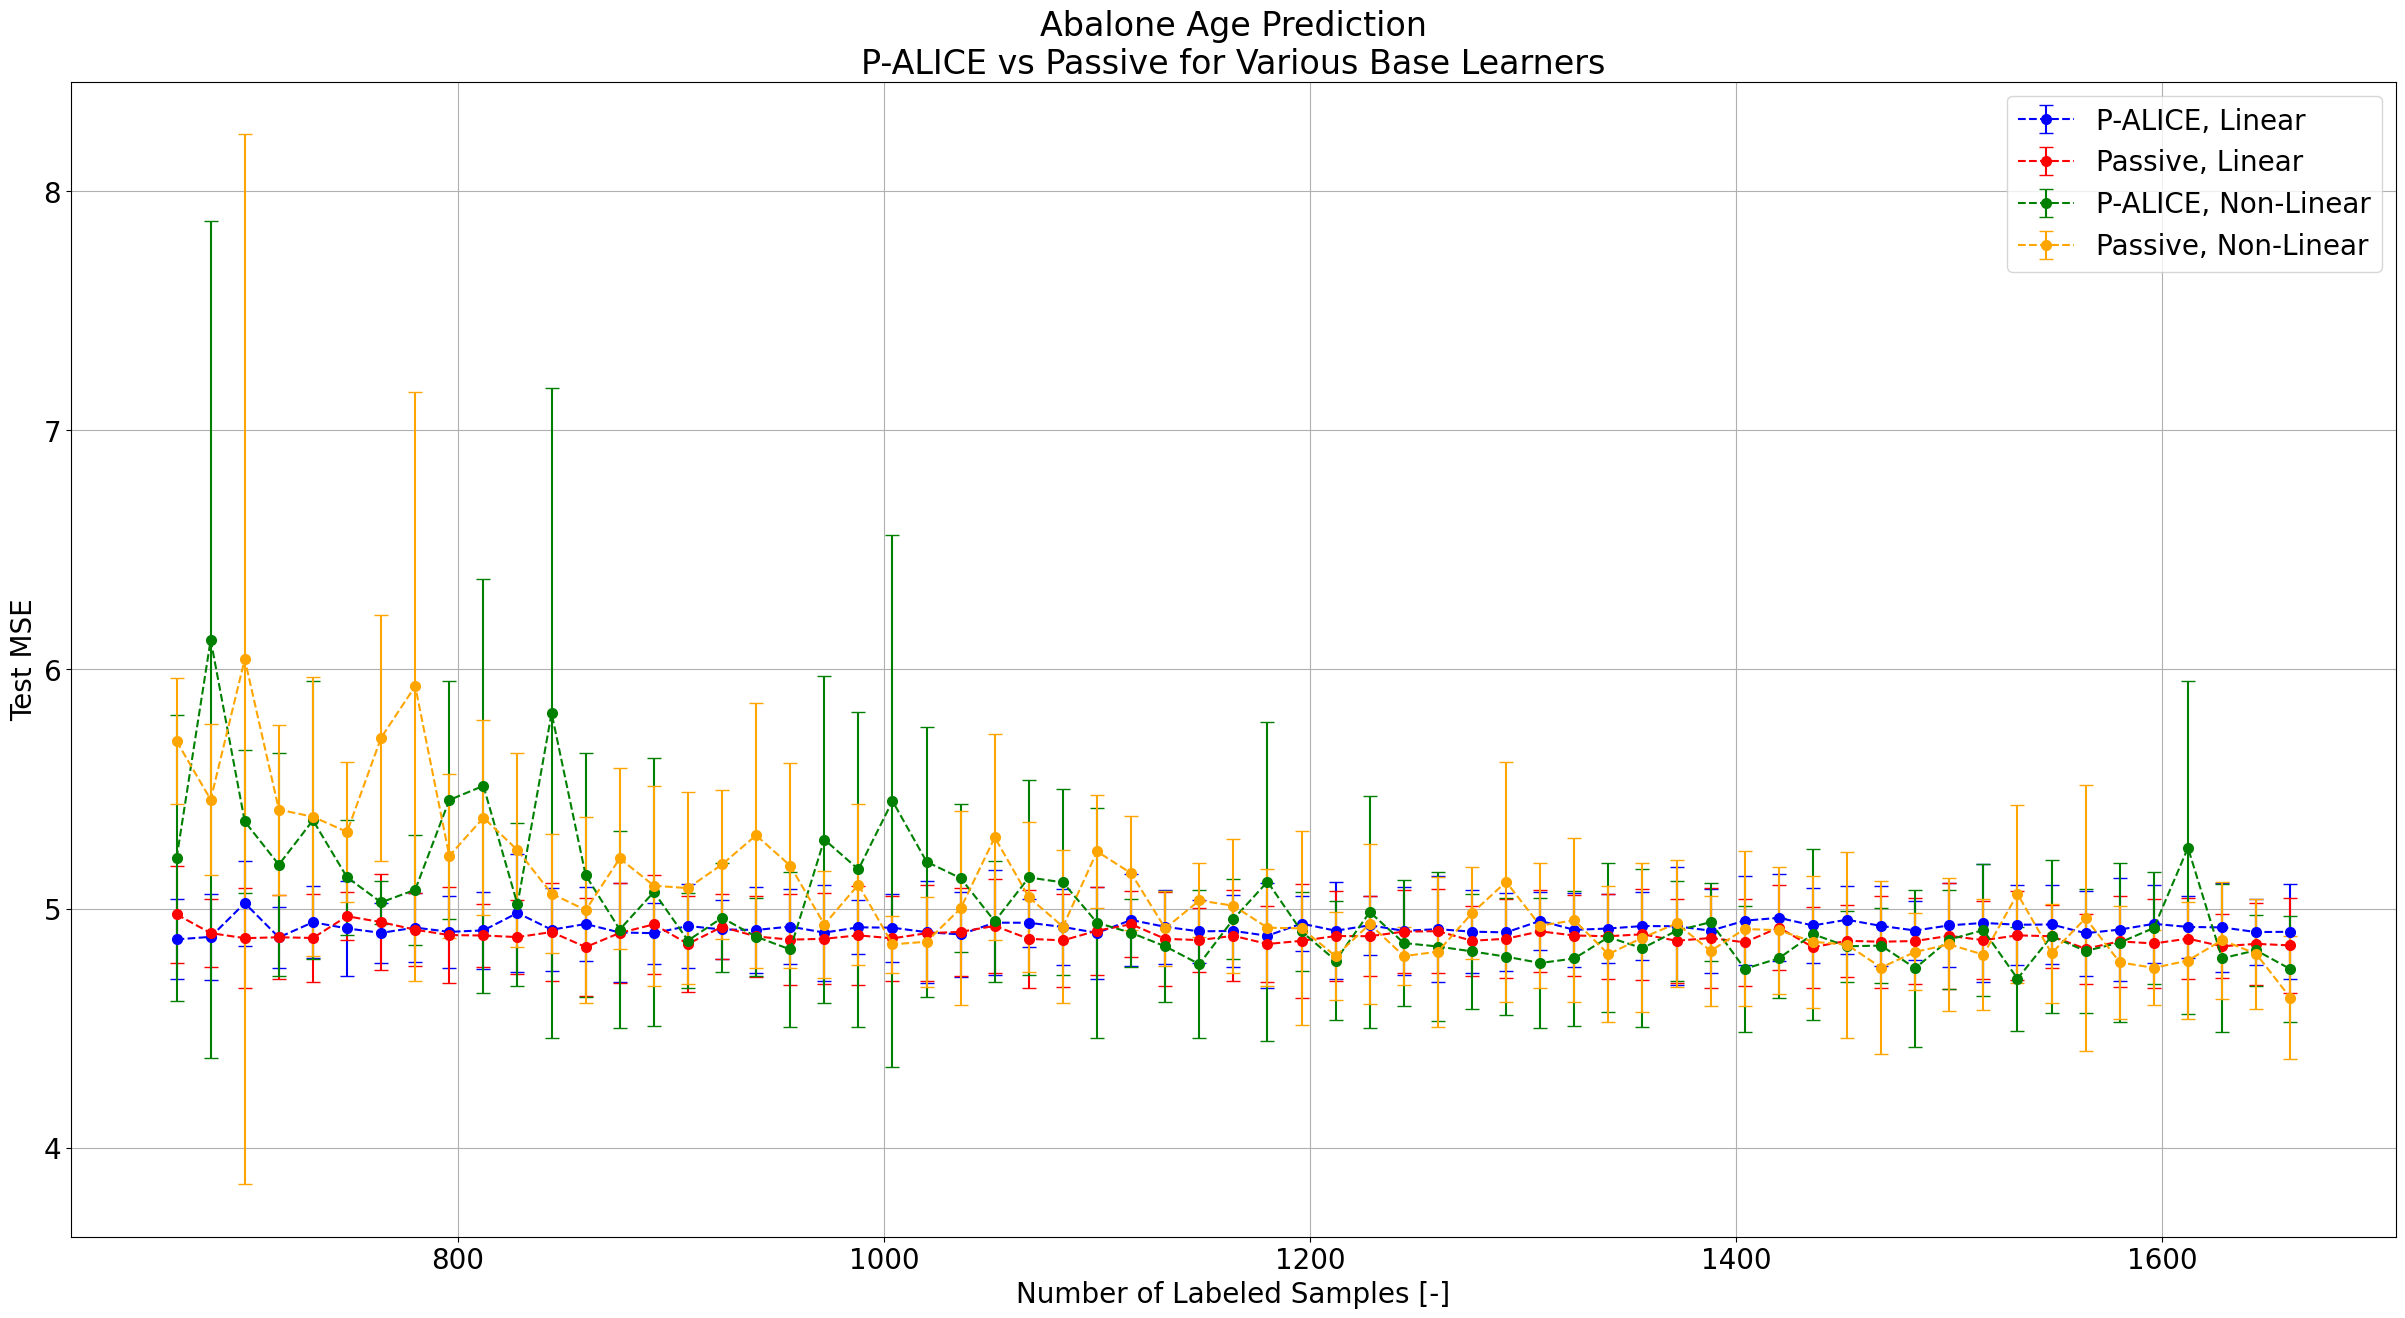

In [43]:
stepsize = 1
# using rc_context to change font size temporarily
with plt.rc_context({'font.size': 20}):
    plt.figure(figsize=(30,15)) 
    # plot scatter plots with error bars
    plt.errorbar(x=num_samples_axis[::stepsize],y=means_1_active[::stepsize], yerr=stds_1_active[::stepsize], fmt='o--', color='b', ecolor='b', capsize=5, markersize=7, label='P-ALICE, Linear')
    plt.errorbar(x=num_samples_axis[::stepsize],y=means_1_passive[::stepsize], yerr=stds_1_passive[::stepsize], fmt='o--', color='r', ecolor='r', capsize=5, markersize=7, label='Passive, Linear')
    plt.errorbar(x=num_samples_axis[::stepsize],y=means_palice_nonlinear[::stepsize], yerr=stds_palice_nonlinear[::stepsize], fmt='o--', color='g', ecolor='g', capsize=5, markersize=7, label='P-ALICE, Non-Linear')
    plt.errorbar(x=num_samples_axis[::stepsize],y=means_passive_nonlinear[::stepsize], yerr=stds_passive_nonlinear[::stepsize], fmt='o--', color='orange', ecolor='orange', capsize=5, markersize=7, label='Passive, Non-Linear')

    # customize plot
    plt.xlabel('Number of Labeled Samples [-]')
    # plt.xticks(x, x)
    plt.ylabel('Test MSE')
    plt.legend()
    plt.title('Abalone Age Prediction\nP-ALICE vs Passive for Various Base Learners')
    plt.grid(True)
plt.show()